In [ ]:
CELL 1 — installs

In [ ]:

!pip install -q xgboost shap h3 osmnx torch_geometric

import os
import numpy as np
import pandas as pd

import osmnx as ox
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import TransformerConv

np.random.seed(42)
torch.manual_seed(42)

DATA_PATH  = "collisions_with_datetime.csv"   # adjust if needed
OUTPUT_DIR = "./travel_london"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("OSMnx:", ox.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.0 MB/s eta 0:00:00
OSMnx: 2.0.6


CELL 2 — load + filter collisions

In [ ]:

usecols = None
df = pd.read_csv(DATA_PATH, usecols=usecols)

# Ensure datetime column
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
elif {'date', 'time'}.issubset(df.columns):
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
else:
    raise ValueError("No datetime or date+time columns found.")

# Filter years
if 'collision_year' in df.columns:
    df = df[(df['collision_year'] >= 2020) & (df['collision_year'] <= 2024)]
else:
    df = df[(df['datetime'].dt.year >= 2020) & (df['datetime'].dt.year <= 2024)]

df = df.dropna(subset=['longitude', 'latitude'])
print("All collisions after filter:", df.shape)

# Restrict to Greater London
if 'local_authority_ons_district' in df.columns:
    df_london = df[df['local_authority_ons_district'].astype(str).str.startswith("E09")]
else:
    df_london = df[
        (df['longitude'] >= -0.6) & (df['longitude'] <= 0.4) &
        (df['latitude']  >= 51.2) & (df['latitude']  <= 51.8)
    ]

df_london = df_london.copy()
print("London collisions:", df_london.shape)
df_london.head()

# ===== BOROUGH TIME-SERIES (safe add-on) =====
# Uses existing df_london; does NOT change it (works on a copy)

df_borough = df_london.copy()

# If datetime not already parsed above, ensure it here safely
if not np.issubdtype(df_borough["datetime"].dtype, np.datetime64):
    df_borough["datetime"] = pd.to_datetime(df_borough["datetime"])

BOROUGH_COL = "local_authority_ons_district"   # stable code per borough
FREQ = "M"   # "M" monthly, "W" weekly, "D" daily

borough_ts_long = (
    df_borough
    .set_index("datetime")
    .groupby(BOROUGH_COL)
    .resample(FREQ)
    .size()
    .rename("collisions")
    .reset_index()
)

borough_ts_wide = borough_ts_long.pivot(
    index="datetime", columns=BOROUGH_COL, values="collisions"
).fillna(0).astype(int)

print("Borough TS long head:")
display(borough_ts_long.head())
print("Borough TS wide head:")
display(borough_ts_wide.head())

# Optional save
borough_ts_long.to_csv(os.path.join(OUTPUT_DIR, f"borough_timeseries_long_{FREQ}.csv"), index=False)
borough_ts_wide.to_csv(os.path.join(OUTPUT_DIR, f"borough_timeseries_wide_{FREQ}.csv"))
print("Saved borough time series to OUTPUT_DIR.")
# ===== END BOROUGH TIME-SERIES =====



All collisions after filter: (193743, 45)
London collisions: (42817, 45)


/tmp/ipython-input-2076205619.py:51: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(FREQ)


Borough TS long head:


,local_authority_ons_district,datetime,collisions
0,E09000001,2020-01-31,5
1,E09000001,2020-02-29,10
2,E09000001,2020-03-31,3
3,E09000001,2020-04-30,2
4,E09000001,2020-05-31,3


Borough TS wide head:


local_authority_ons_district,E09000001,E09000002,E09000003,E09000004,E09000005,E09000006,E09000007,E09000008,E09000009,E09000010,...,E09000024,E09000025,E09000026,E09000027,E09000028,E09000029,E09000030,E09000031,E09000032,E09000033
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-31,5,9,31,18,27,19,22,30,32,45,...,20,27,26,7,38,15,23,24,29,36
2020-02-29,10,11,33,12,27,12,31,31,32,27,...,12,23,29,15,31,12,29,23,22,42
2020-03-31,3,5,16,10,24,11,16,29,25,22,...,9,16,20,9,27,9,24,17,22,25
2020-04-30,2,4,10,6,14,7,11,12,6,14,...,3,6,4,6,13,2,20,6,12,8
2020-05-31,3,12,25,9,14,15,16,12,13,27,...,12,13,13,12,13,6,13,18,18,23


Saved borough time series to OUTPUT_DIR.


CELL 3 — download OSM graph for London

In [ ]:

place_name = "Greater London, United Kingdom"
ox.settings.log_console = True

G = ox.graph_from_place(place_name, network_type="drive")

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.add_edge_bearings(G)

print(G)


MultiDiGraph with 130536 nodes and 303799 edges


CELL 4 — nodes/edges GeoDataFrames + map collisions to nearest node

In [ ]:

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# osmid -> contiguous index
node_id_to_idx = {nid: i for i, nid in enumerate(nodes.index.values)}
nodes['node_idx'] = nodes.index.map(node_id_to_idx)

print("Num nodes:", len(nodes))

from osmnx import distance as ox_distance
collision_x = df_london['longitude'].values
collision_y = df_london['latitude'].values

nearest_nodes = ox_distance.nearest_nodes(G, collision_x, collision_y)
df_london['nearest_node'] = nearest_nodes
df_london.head()


Num nodes: 130536


,collision_index,collision_year,collision_ref_no,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,collision_severity,number_of_vehicles,...,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,collision_injury_based,collision_adjusted_severity_serious,collision_adjusted_severity_slight,datetime,nearest_node
915,2022481271944,2022,481271944,531556.0,181648.0,-0.105334,51.518443,48,2.0,1.0,...,1.0,3.0,2.0,E01032740,7.0,1.0,1.0,0.0,2022-08-31 20:29:00,14672924
916,2023481377458,2023,481377458,532184.0,181047.0,-0.096513,51.512895,48,2.0,2.0,...,1.0,3.0,2.0,E01032739,7.0,1.0,1.0,0.0,2023-08-11 23:30:00,7223709669
917,2024481567216,2024,481567216,531635.0,181176.0,-0.104370,51.514180,48,2.0,2.0,...,1.0,3.0,2.0,E01032740,7.0,1.0,1.0,0.0,2024-11-04 19:54:00,237908
918,2020010232422,2020,010232422,544201.0,183835.0,0.077711,51.535010,1,3.0,1.0,...,1.0,1.0,2.0,E01000010,-1.0,0.0,0.0,1.0,2020-01-23 19:30:00,1576874705
919,2020010233922,2020,010233922,546840.0,183837.0,0.115734,51.534348,1,3.0,4.0,...,1.0,1.0,2.0,E01000045,-1.0,0.0,0.0,1.0,2020-02-01 14:01:00,6275553591


CELL 5 — labels: occurrence + risk/severity_8labels (same logic)

In [ ]:

# Accident count per node
node_acc_count = df_london.groupby('nearest_node').size()

# Choose severity column
severity_col = None
for cand in ['collision_severity', 'enhanced_severity_collision']:
    if cand in df_london.columns:
        severity_col = cand
        break
if severity_col is None:
    raise ValueError("No severity column found. Set severity_col manually.")

node_max_sev = df_london.groupby('nearest_node')[severity_col].max()

nodes['acc_count'] = nodes.index.map(node_acc_count).fillna(0).astype(int)
nodes['occur_label'] = (nodes['acc_count'] > 0).astype(int)
nodes['max_severity_raw'] = nodes.index.map(node_max_sev)

# Risk score
sev_weight = {1: 3.0, 2: 2.0, 3: 1.0}
def row_score(sub):
    return sum(sev_weight.get(s, 0.0) for s in sub[severity_col])

score_series = df_london.groupby('nearest_node').apply(row_score, include_groups=False)
nodes['risk_score'] = nodes.index.map(score_series).fillna(0.0)

# 8-label bins: 0=no accidents, 1–7 quantiles of nonzero risk
nonzero = nodes['risk_score'] > 0
nodes['severity_8labels'] = 0
if nonzero.sum() > 0:
    n_unique = nodes.loc[nonzero, 'risk_score'].nunique()
    effective_q = min(7, n_unique)
    if effective_q > 0:
        binned = pd.qcut(nodes.loc[nonzero, 'risk_score'], q=effective_q, duplicates='drop')
        nodes.loc[nonzero, 'severity_8labels'] = binned.cat.codes + 1
    else:
        nodes.loc[nonzero, 'severity_8labels'] = 1

nodes['severity_8labels'] = nodes['severity_8labels'].astype(int)

nodes[['acc_count','occur_label','risk_score','severity_8labels']].head()


,acc_count,occur_label,risk_score,severity_8labels
osmid,,,,
78112,1,1,1.0,1
99936,0,0,0.0,0
99937,1,1,1.0,1
101818,6,1,7.0,3
101831,1,1,1.0,1


CELL 6 — node features (same topological + road-type setup)

In [ ]:

G_und = G.to_undirected()
deg = dict(G_und.degree())
nodes['degree'] = nodes.index.map(deg).fillna(0)

edges_simple = edges.copy()
edges_simple['u_osmid'] = edges_simple.index.get_level_values(0)
edges_simple['v_osmid'] = edges_simple.index.get_level_values(1)

def agg_edge_features(group):
    return pd.Series({
        'mean_length': group['length'].mean(),
        'mean_speed_kph': group['speed_kph'].mean() if 'speed_kph' in group else np.nan
    })

u_agg = edges_simple.groupby('u_osmid').apply(agg_edge_features, include_groups=False)
v_agg = edges_simple.groupby('v_osmid').apply(agg_edge_features, include_groups=False)
agg = u_agg.add(v_agg, fill_value=0) / 2.0
nodes = nodes.merge(agg, left_index=True, right_index=True, how='left')

for c in ['mean_length', 'mean_speed_kph']:
    if c not in nodes.columns:
        nodes[c] = 0.0

def highway_list(group):
    vals = []
    for v in group['highway']:
        if isinstance(v, list): vals.extend(v)
        else: vals.append(v)
    return vals

u_hw = edges_simple.groupby('u_osmid').apply(highway_list, include_groups=False)
v_hw = edges_simple.groupby('v_osmid').apply(highway_list, include_groups=False)

hw = {}
for k in set(u_hw.index).union(v_hw.index):
    hw[k] = list(set((u_hw.get(k, []) or []) + (v_hw.get(k, []) or [])))
nodes['highway_raw'] = nodes.index.map(hw)

all_hw = [h for lst in nodes['highway_raw'].dropna() for h in lst]
top_hw = pd.Series(all_hw).value_counts().head(10).index.tolist()

for h in top_hw:
    nodes[f'highway_{h}'] = nodes['highway_raw'].apply(
        lambda lst: int(isinstance(lst, list) and (h in lst))
    )

# Exclude 'highway_raw' explicitly to avoid ValueError
feat_cols = ['degree','mean_length','mean_speed_kph'] + \
            [c for c in nodes.columns if c.startswith('highway_') and c != 'highway_raw']

nodes[feat_cols] = nodes[feat_cols].fillna(0)

scaler = StandardScaler()
x = scaler.fit_transform(nodes[feat_cols].values).astype(np.float32)

print("Node feature shape:", x.shape)
len(feat_cols), feat_cols[:10]

Node feature shape: (130536, 13)


(13,
 ['degree',
  'mean_length',
  'mean_speed_kph',
  'highway_residential',
  'highway_primary',
  'highway_tertiary',
  'highway_unclassified',
  'highway_secondary',
  'highway_trunk',
  'highway_trunk_link'])

CELL 7 — build edge_index + edge_attr + coords + save NPZ

In [ ]:

edge_u, edge_v, edge_attr = [], [], []

for u, v, k, data_e in G.edges(keys=True, data=True):
    if u not in node_id_to_idx or v not in node_id_to_idx:
        continue
    ui, vi = node_id_to_idx[u], node_id_to_idx[v]
    edge_u.append(ui); edge_v.append(vi)

    length = float(data_e.get("length", 0.0))
    speed  = float(data_e.get("speed_kph", 0.0)) if "speed_kph" in data_e else 0.0
    ttime  = float(data_e.get("travel_time", 0.0)) if "travel_time" in data_e else 0.0
    edge_attr.append([length, speed, ttime])

edge_index = np.vstack([edge_u, edge_v]).astype(np.int64)
edge_attr  = np.array(edge_attr, dtype=np.float32)

coordinates = nodes[['y','x']].values.astype(np.float32)
cnt_labels = nodes['acc_count'].values.astype(np.int64)
occur_labels = nodes['occur_label'].values.astype(np.int64)
severity_8labels = nodes['severity_8labels'].values.astype(np.int64)

node_hour = df_london.groupby('nearest_node')['datetime'].apply(lambda s: s.dt.hour.mean())
crash_time = nodes.index.map(node_hour).fillna(-1).values.astype(np.float32)

print("edge_index:", edge_index.shape, "edge_attr:", edge_attr.shape)

out_path = os.path.join(OUTPUT_DIR, "london_travel_dataset_TRANSFORMER_XGB.npz")
np.savez_compressed(
    out_path,
    x=x,
    coordinates=coordinates,
    edge_index=edge_index,
    edge_attr=edge_attr,
    cnt_labels=cnt_labels,
    occur_labels=occur_labels,
    severity_8labels=severity_8labels,
    crash_time=crash_time,
    feat_cols=np.array(feat_cols, dtype=object)
)
print("Saved to:", out_path)


edge_index: (2, 303799) edge_attr: (303799, 3)
Saved to: ./travel_london/london_travel_dataset_TRANSFORMER_XGB.npz


CELL 8 — load NPZ -> PyG Data

In [ ]:

def read_npz(path):
    f = np.load(path, allow_pickle=True)
    data = Data(
        x=torch.from_numpy(f['x']).float(),
        edge_index=torch.from_numpy(f['edge_index']).long(),
        edge_attr=torch.from_numpy(f['edge_attr']).float(),
        coords=torch.from_numpy(f['coordinates']).float(),
        cnt_labels=torch.from_numpy(f['cnt_labels']).long(),
        y=torch.from_numpy(f['occur_labels']).long(),
        severity_labels=torch.from_numpy(f['severity_8labels']).long(),
        crash_time=torch.from_numpy(f['crash_time']).float(),
    )
    return data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = os.path.join(OUTPUT_DIR, "london_travel_dataset_TRANSFORMER_XGB.npz")
data = read_npz(data_path).to(device)

print(data)
print("Num nodes:", data.num_nodes)
print("Num edges:", data.num_edges)
print("x shape:", data.x.shape, "edge_attr shape:", data.edge_attr.shape)


Data(x=[130536, 13], edge_index=[2, 303799], edge_attr=[303799, 3], y=[130536], coords=[130536, 2], cnt_labels=[130536], severity_labels=[130536], crash_time=[130536])
Num nodes: 130536
Num edges: 303799
x shape: torch.Size([130536, 13]) edge_attr shape: torch.Size([303799, 3])


CELL 9 — spatial splits (same rule: east 25% test)

In [ ]:

coords = data.coords.cpu().numpy()
y_occ = data.y.cpu().numpy()
y_sev = data.severity_labels.cpu().numpy()
num_nodes = data.num_nodes

def make_spatial_split_occurrence(y, coords, test_q=0.75, val_ratio=0.15, seed=42):
    lon = coords[:, 1]
    thr = np.quantile(lon, test_q)
    test_mask = lon >= thr

    remain_idx = np.where(~test_mask)[0]
    train_idx, val_idx = train_test_split(
        remain_idx, test_size=val_ratio,
        stratify=y[remain_idx], random_state=seed
    )

    train_mask = np.zeros(len(y), bool); val_mask = np.zeros(len(y), bool)
    train_mask[train_idx] = True; val_mask[val_idx] = True
    return (train_mask, val_mask, test_mask)

def make_spatial_split_severity(y, coords, test_q=0.75, val_ratio=0.15, seed=42):
    lon = coords[:, 1]
    thr = np.quantile(lon, test_q)
    test_mask = lon >= thr

    nonzero_idx = np.where(y > 0)[0]
    remain_idx = np.where(~test_mask)[0]
    remain_idx_nonzero = np.intersect1d(remain_idx, nonzero_idx)

    if len(remain_idx_nonzero) == 0:
        raise ValueError("Not enough non-zero severity labels for val split.")

    train_idx_nz, val_idx_nz = train_test_split(
        remain_idx_nonzero, test_size=val_ratio,
        stratify=y[remain_idx_nonzero], random_state=seed
    )

    train_mask = np.zeros(len(y), bool); val_mask = np.zeros(len(y), bool)
    train_mask[train_idx_nz] = True; val_mask[val_idx_nz] = True

    zero_idx = np.where(y == 0)[0]
    zero_train = zero_idx[~test_mask[zero_idx]]
    train_mask[zero_train] = True

    return (train_mask, val_mask, test_mask)

train_mask_occ, val_mask_occ, test_mask_occ = make_spatial_split_occurrence(y_occ, coords)
train_mask_sev, val_mask_sev, test_mask_sev = make_spatial_split_severity(y_sev, coords)

data.train_mask_occ = torch.from_numpy(train_mask_occ).to(device)
data.val_mask_occ   = torch.from_numpy(val_mask_occ).to(device)
data.test_mask_occ  = torch.from_numpy(test_mask_occ).to(device)

data.train_mask_sev = torch.from_numpy(train_mask_sev).to(device)
data.val_mask_sev   = torch.from_numpy(val_mask_sev).to(device)
data.test_mask_sev  = torch.from_numpy(test_mask_sev).to(device)

print("Occurrence masks:",
      int(train_mask_occ.sum()), int(val_mask_occ.sum()), int(test_mask_occ.sum()))
print("Severity masks:",
      int(train_mask_sev.sum()), int(val_mask_sev.sum()), int(test_mask_sev.sum()))


Occurrence masks: 83216 14686 32634
Severity masks: 94880 3022 32634


CELL 10 — TransformerConv model

In [ ]:

class TransformerNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, edge_dim, heads=4, dropout=0.5):
        super().__init__()
        self.conv1 = TransformerConv(
            in_dim, hidden_dim, heads=heads, concat=True,
            edge_dim=edge_dim, dropout=dropout
        )
        self.conv2 = TransformerConv(
            hidden_dim * heads, out_dim, heads=1, concat=False,
            edge_dim=edge_dim, dropout=dropout
        )
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x


In [ ]:
# === TRIVIAL BASELINES: OCCURRENCE ===
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import numpy as np

X = data.x.cpu().numpy()
y_occ = data.y.cpu().numpy()

train_idx = np.where(data.train_mask_occ.cpu().numpy())[0]
test_idx  = np.where(data.test_mask_occ.cpu().numpy())[0]

y_train = y_occ[train_idx]
y_test  = y_occ[test_idx]

# ---- Baseline 1: Majority class predictor ----
maj_class = int(np.bincount(y_train).argmax())
pred_maj = np.full_like(y_test, maj_class)

print("\n[Trivial-occ Majority] Test report:")
print(classification_report(y_test, pred_maj, digits=3))
print("[Trivial-occ Majority] macro-F1:",
      round(f1_score(y_test, pred_maj, average="macro"), 3))

# ---- Baseline 2: Random guess with train positive rate ----
p_pos = y_train.mean()
prob_rand = np.full_like(y_test, p_pos, dtype=float)
pred_rand = (np.random.rand(len(y_test)) < p_pos).astype(int)

print("\n[Trivial-occ Random] Test report:")
print(classification_report(y_test, pred_rand, digits=3))
print("[Trivial-occ Random] macro-F1:",
      round(f1_score(y_test, pred_rand, average="macro"), 3))
print("[Trivial-occ Random] ROC-AUC:",
      round(roc_auc_score(y_test, prob_rand), 3))



[Trivial-occ Majority] Test report:
              precision    recall  f1-score   support

           0      0.853     1.000     0.921     27841
           1      0.000     0.000     0.000      4793

    accuracy                          0.853     32634
   macro avg      0.427     0.500     0.460     32634
weighted avg      0.728     0.853     0.786     32634

[Trivial-occ Majority] macro-F1: 0.46

[Trivial-occ Random] Test report:
              precision    recall  f1-score   support

           0      0.855     0.797     0.825     27841
           1      0.152     0.212     0.177      4793

    accuracy                          0.711     32634
   macro avg      0.504     0.505     0.501     32634
weighted avg      0.751     0.711     0.730     32634

[Trivial-occ Random] macro-F1: 0.501
[Trivial-occ Random] ROC-AUC: 0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cell 11 TRIVIAL BASELINES: SEVERITY

In [ ]:

from sklearn.metrics import classification_report, f1_score
import numpy as np

y_sev = data.severity_labels.cpu().numpy()

train_idx = np.where(data.train_mask_sev.cpu().numpy())[0]
test_idx  = np.where(data.test_mask_sev.cpu().numpy())[0]

y_train = y_sev[train_idx]
y_test  = y_sev[test_idx]

# Majority class over TRAIN (including zeros)
maj_sev = int(np.bincount(y_train).argmax())
pred_maj_sev = np.full_like(y_test, maj_sev)

print("\n[Trivial-sev Majority] Test report:")
print(classification_report(y_test, pred_maj_sev, digits=3))
print("[Trivial-sev Majority] macro-F1:",
      round(f1_score(y_test, pred_maj_sev, average="macro"), 3))

# Optional: random guess from train class distribution
train_dist = np.bincount(y_train) / len(y_train)
pred_rand_sev = np.random.choice(np.arange(len(train_dist)),
                                 size=len(y_test),
                                 p=train_dist)

print("\n[Trivial-sev Random] Test report:")
print(classification_report(y_test, pred_rand_sev, digits=3))
print("[Trivial-sev Random] macro-F1:",
      round(f1_score(y_test, pred_rand_sev, average="macro"), 3))



[Trivial-sev Majority] Test report:
              precision    recall  f1-score   support

           0      0.853     1.000     0.921     27841
           1      0.000     0.000     0.000      3952
           2      0.000     0.000     0.000       442
           3      0.000     0.000     0.000       399

    accuracy                          0.853     32634
   macro avg      0.213     0.250     0.230     32634
weighted avg      0.728     0.853     0.786     32634

[Trivial-sev Majority] macro-F1: 0.23

[Trivial-sev Random] Test report:
              precision    recall  f1-score   support

           0      0.852     0.820     0.835     27841
           1      0.122     0.139     0.130      3952
           2      0.010     0.014     0.011       442
           3      0.015     0.028     0.019       399

    accuracy                          0.717     32634
   macro avg      0.250     0.250     0.249     32634
weighted avg      0.742     0.717     0.729     32634

[Trivial-sev Random]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CELL 12 — train/eval TransformerConv for OCCURRENCE

In [ ]:

in_dim = data.x.size(1)
edge_dim = data.edge_attr.size(1)
num_classes_occ = int(data.y.max().item() + 1)

model_occ = TransformerNet(in_dim, 64, num_classes_occ, edge_dim=edge_dim).to(device)
opt_occ = torch.optim.Adam(model_occ.parameters(), lr=1e-3, weight_decay=5e-4)

def train_epoch(model, opt, y, train_mask):
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[train_mask], y[train_mask])
    loss.backward()
    opt.step()
    return loss.item()

def eval_epoch(model, y, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        preds = out.argmax(dim=1)
        f1 = f1_score(y[mask].cpu().numpy(), preds[mask].cpu().numpy(), average='macro')
    return f1, preds

y_occ_t = data.y
for epoch in range(1, 81):
    loss = train_epoch(model_occ, opt_occ, y_occ_t, data.train_mask_occ)
    if epoch % 20 == 0:
        val_f1, _ = eval_epoch(model_occ, y_occ_t, data.val_mask_occ)
        print(f"[Transformer-occ] Epoch {epoch:03d} | Loss {loss:.4f} | Val macro-F1 {val_f1:.3f}")

test_f1_occ, pred_occ = eval_epoch(model_occ, y_occ_t, data.test_mask_occ)
print("\n[Transformer-occ] Test report:")
print(classification_report(
    y_occ_t[data.test_mask_occ].cpu().numpy(),
    pred_occ[data.test_mask_occ].cpu().numpy(),
    digits=3
))


[Transformer-occ] Epoch 020 | Loss 13.7484 | Val macro-F1 0.501
[Transformer-occ] Epoch 040 | Loss 7.6464 | Val macro-F1 0.567
[Transformer-occ] Epoch 060 | Loss 5.1417 | Val macro-F1 0.577
[Transformer-occ] Epoch 080 | Loss 4.3446 | Val macro-F1 0.575

[Transformer-occ] Test report:
              precision    recall  f1-score   support

           0      0.871     0.936     0.902     27841
           1      0.346     0.198     0.252      4793

    accuracy                          0.827     32634
   macro avg      0.609     0.567     0.577     32634
weighted avg      0.794     0.827     0.807     32634



CELL 13 — train/eval TransformerConv for SEVERITY

In [ ]:

num_classes_sev = int(data.severity_labels.max().item() + 1)

model_sev = TransformerNet(in_dim, 64, num_classes_sev, edge_dim=edge_dim).to(device)
opt_sev = torch.optim.Adam(model_sev.parameters(), lr=1e-3, weight_decay=5e-4)

y_sev_t = data.severity_labels
for epoch in range(1, 81):
    loss = train_epoch(model_sev, opt_sev, y_sev_t, data.train_mask_sev)
    if epoch % 20 == 0:
        val_f1, _ = eval_epoch(model_sev, y_sev_t, data.val_mask_sev)
        print(f"[Transformer-sev] Epoch {epoch:03d} | Loss {loss:.4f} | Val macro-F1 {val_f1:.3f}")

test_f1_sev, pred_sev = eval_epoch(model_sev, y_sev_t, data.test_mask_sev)
print("\n[Transformer-sev] Test report:")
print(classification_report(
    y_sev_t[data.test_mask_sev].cpu().numpy(),
    pred_sev[data.test_mask_sev].cpu().numpy(),
    digits=3
))


[Transformer-sev] Epoch 020 | Loss 13.1225 | Val macro-F1 0.000
[Transformer-sev] Epoch 040 | Loss 8.5684 | Val macro-F1 0.000
[Transformer-sev] Epoch 060 | Loss 5.8026 | Val macro-F1 0.000
[Transformer-sev] Epoch 080 | Loss 4.1160 | Val macro-F1 0.001

[Transformer-sev] Test report:
              precision    recall  f1-score   support

           0      0.854     0.999     0.920     27841
           1      0.246     0.004     0.007      3952
           2      0.000     0.000     0.000       442
           3      0.000     0.000     0.000       399

    accuracy                          0.852     32634
   macro avg      0.275     0.251     0.232     32634
weighted avg      0.758     0.852     0.786     32634



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CELL 14 — XGBoost baseline for OCCURRENCE

In [ ]:

from xgboost import XGBClassifier

X = data.x.cpu().numpy()
y_occ = data.y.cpu().numpy()

train_idx = np.where(train_mask_occ)[0]
test_idx  = np.where(test_mask_occ)[0]

xgb_occ = XGBClassifier(
    n_estimators=800,
    max_depth=5,
    learning_rate=5,
    subsample=0.2,
    colsample_bytree=0.2,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    tree_method='hist',
    random_state=42
)
xgb_occ.fit(X[train_idx], y_occ[train_idx])

pred_occ_xgb = xgb_occ.predict(X[test_idx])
prob_occ_xgb = xgb_occ.predict_proba(X[test_idx])[:, 1]

print("[XGB-occ] Test report:")
print(classification_report(y_occ[test_idx], pred_occ_xgb, digits=3))
print("[XGB-occ] ROC-AUC:", round(roc_auc_score(y_occ[test_idx], prob_occ_xgb), 3))


[XGB-occ] Test report:
              precision    recall  f1-score   support

           0      0.897     0.919     0.908     27841
           1      0.449     0.385     0.415      4793

    accuracy                          0.840     32634
   macro avg      0.673     0.652     0.661     32634
weighted avg      0.831     0.840     0.835     32634

[XGB-occ] ROC-AUC: 0.652


Cell 15 — XGBoost baseline for SEVERITY

In [ ]:

y_sev = data.severity_labels.cpu().numpy()

train_idx = np.where(train_mask_sev)[0]
test_idx  = np.where(test_mask_sev)[0]

xgb_sev = XGBClassifier(
    n_estimators=3000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=int(y_sev.max() + 1),
    eval_metric='mlogloss',
    n_jobs=-1,
    tree_method='hist',
    random_state=42
)
xgb_sev.fit(X[train_idx], y_sev[train_idx])

pred_sev_xgb = xgb_sev.predict(X[test_idx])

print("[XGB-sev] Test report:")
print(classification_report(y_sev[test_idx], pred_sev_xgb, digits=3))


[XGB-sev] Test report:
              precision    recall  f1-score   support

           0      0.875     0.963     0.917     27841
           1      0.332     0.135     0.192      3952
           2      0.049     0.016     0.024       442
           3      0.158     0.093     0.117       399

    accuracy                          0.839     32634
   macro avg      0.353     0.302     0.312     32634
weighted avg      0.789     0.839     0.807     32634



CELL 16 (optional) — export Transformer occurrence risk as CSV + quick plot

In [ ]:

model_occ.eval()
with torch.no_grad():
    logits = model_occ(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

coords_np = data.coords.cpu().numpy()
risk_df = pd.DataFrame({
    'lat': coords_np[:, 0],
    'lon': coords_np[:, 1],
    'p_crash': probs,
    'occur_label': y_occ
})
risk_df.to_csv(os.path.join(OUTPUT_DIR, "node_risk_occurrence_transformer.csv"), index=False)
risk_df.head()


,lat,lon,p_crash,occur_label
0,51.526978,-0.145792,2.555469e-02,1
1,51.523628,-0.152799,3.575396e-03,0
2,51.523018,-0.152023,1.943662e-04,1
3,51.535183,-0.148105,5.484911e-09,1
4,51.535610,-0.147044,5.459300e-07,1


CELL 17 — edge attributes: basic vs full (dir + bearing)

In [ ]:

import numpy as np

# safety checks
assert "x" in nodes.columns and "y" in nodes.columns, "nodes must have x,y lon/lat"
assert isinstance(node_id_to_idx, dict), "node_id_to_idx missing"

edge_u, edge_v = [], []
edge_attr_basic = []
edge_attr_full  = []

for u, v, k, data_e in G.edges(keys=True, data=True):
    if u not in node_id_to_idx or v not in node_id_to_idx:
        continue

    ui, vi = node_id_to_idx[u], node_id_to_idx[v]
    edge_u.append(ui)
    edge_v.append(vi)

    length = float(data_e.get("length", 0.0))
    speed  = float(data_e.get("speed_kph", 0.0)) if "speed_kph" in data_e else 0.0
    ttime  = float(data_e.get("travel_time", 0.0)) if "travel_time" in data_e else 0.0

    # Direction unit vector u->v in lon/lat
    x_u, y_u = G.nodes[u]["x"], G.nodes[u]["y"]
    x_v, y_v = G.nodes[v]["x"], G.nodes[v]["y"]
    dx, dy = x_v - x_u, y_v - y_u
    n = (dx**2 + dy**2)**0.5 + 1e-8
    dir_x, dir_y = dx/n, dy/n

    # Bearing cos/sin
    bearing = float(data_e.get("bearing", 0.0))
    rad = np.deg2rad(bearing)
    cos_b, sin_b = np.cos(rad), np.sin(rad)

    edge_attr_basic.append([length, speed, ttime])
    edge_attr_full.append([length, speed, ttime, dir_x, dir_y, cos_b, sin_b])

edge_index = np.vstack([edge_u, edge_v]).astype(np.int64)
edge_attr_basic = np.array(edge_attr_basic, dtype=np.float32)
edge_attr_full  = np.array(edge_attr_full,  dtype=np.float32)

print("edge_index:", edge_index.shape)
print("edge_attr_basic:", edge_attr_basic.shape)
print("edge_attr_full:", edge_attr_full.shape)

# store on data object for easy switching
data.edge_index = torch.from_numpy(edge_index).long().to(device)
data.edge_attr_basic = torch.from_numpy(edge_attr_basic).float().to(device)
data.edge_attr_full  = torch.from_numpy(edge_attr_full).float().to(device)


edge_index: (2, 303799)
edge_attr_basic: (303799, 3)
edge_attr_full: (303799, 7)


CELL 18 — ablation: TransformerConv basic vs full edge features

In [ ]:

from sklearn.metrics import classification_report, f1_score, average_precision_score, roc_auc_score

def train_transformer_task(y, train_mask, val_mask, test_mask, edge_attr, hidden=64, epochs=80):
    in_dim = data.x.size(1)
    edge_dim = edge_attr.size(1)
    num_classes = int(y.max().item() + 1)

    model = TransformerNet(in_dim, hidden, num_classes, edge_dim=edge_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

    for epoch in range(1, epochs + 1):
        model.train()
        opt.zero_grad()
        out = model(data.x, data.edge_index, edge_attr)
        loss = F.cross_entropy(out[train_mask], y[train_mask])
        loss.backward()
        opt.step()

        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                preds = out.argmax(dim=1)
                val_f1 = f1_score(
                    y[val_mask].cpu().numpy(),
                    preds[val_mask].cpu().numpy(),
                    average="macro"
                )
            print(f"Epoch {epoch:03d} | Loss {loss.item():.4f} | Val macro-F1 {val_f1:.3f}")

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, edge_attr)
        preds = out.argmax(dim=1)

    print("\nTest report:")
    print(classification_report(
        y[test_mask].cpu().numpy(),
        preds[test_mask].cpu().numpy(),
        digits=3
    ))
    return model, preds, out

print("=== OCCURRENCE: BASIC EDGE FEATS ===")
model_occ_basic, pred_occ_basic, logits_occ_basic = train_transformer_task(
    data.y, data.train_mask_occ, data.val_mask_occ, data.test_mask_occ, data.edge_attr_basic
)

print("\n=== OCCURRENCE: FULL EDGE FEATS (dir+bearing) ===")
model_occ_full, pred_occ_full, logits_occ_full = train_transformer_task(
    data.y, data.train_mask_occ, data.val_mask_occ, data.test_mask_occ, data.edge_attr_full
)

print("\n=== SEVERITY: BASIC EDGE FEATS ===")
model_sev_basic, pred_sev_basic, logits_sev_basic = train_transformer_task(
    data.severity_labels, data.train_mask_sev, data.val_mask_sev, data.test_mask_sev, data.edge_attr_basic
)

print("\n=== SEVERITY: FULL EDGE FEATS (dir+bearing) ===")
model_sev_full, pred_sev_full, logits_sev_full = train_transformer_task(
    data.severity_labels, data.train_mask_sev, data.val_mask_sev, data.test_mask_sev, data.edge_attr_full
)


=== OCCURRENCE: BASIC EDGE FEATS ===
Epoch 020 | Loss 10.2305 | Val macro-F1 0.539
Epoch 040 | Loss 6.4937 | Val macro-F1 0.544
Epoch 060 | Loss 5.1179 | Val macro-F1 0.558
Epoch 080 | Loss 4.2219 | Val macro-F1 0.566

Test report:
              precision    recall  f1-score   support

           0      0.873     0.944     0.907     27841
           1      0.383     0.201     0.263      4793

    accuracy                          0.835     32634
   macro avg      0.628     0.572     0.585     32634
weighted avg      0.801     0.835     0.813     32634


=== OCCURRENCE: FULL EDGE FEATS (dir+bearing) ===
Epoch 020 | Loss 11.6450 | Val macro-F1 0.522
Epoch 040 | Loss 9.0156 | Val macro-F1 0.526
Epoch 060 | Loss 7.1249 | Val macro-F1 0.539
Epoch 080 | Loss 5.8471 | Val macro-F1 0.547

Test report:
              precision    recall  f1-score   support

           0      0.865     0.946     0.904     27841
           1      0.310     0.140     0.193      4793

    accuracy                   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 020 | Loss 10.2701 | Val macro-F1 0.114
Epoch 040 | Loss 6.8231 | Val macro-F1 0.099
Epoch 060 | Loss 4.5141 | Val macro-F1 0.108
Epoch 080 | Loss 3.1900 | Val macro-F1 0.095

Test report:
              precision    recall  f1-score   support

           0      0.854     0.999     0.921     27841
           1      0.314     0.003     0.006      3952
           2      0.000     0.000     0.000       442
           3      0.000     0.000     0.000       399

    accuracy                          0.853     32634
   macro avg      0.292     0.251     0.232     32634
weighted avg      0.766     0.853     0.786     32634



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CELL 19 — Multi-task Transformer (occurrence + severity heads)

In [ ]:

class MultiTaskTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, edge_dim, heads=4, dropout=0.5,
                 num_classes_occ=2, num_classes_sev=8):
        super().__init__()
        self.conv1 = TransformerConv(in_dim, hidden_dim, heads=heads, concat=True,
                                     edge_dim=edge_dim, dropout=dropout)
        self.conv2 = TransformerConv(hidden_dim * heads, hidden_dim, heads=1, concat=False,
                                     edge_dim=edge_dim, dropout=dropout)
        self.dropout = dropout

        self.head_occ = nn.Linear(hidden_dim, num_classes_occ)
        self.head_sev = nn.Linear(hidden_dim, num_classes_sev)

    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x, edge_index, edge_attr)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.conv2(h, edge_index, edge_attr)
        h = F.relu(h)
        return self.head_occ(h), self.head_sev(h)

edge_attr = data.edge_attr_full  # use full by default (change to basic for ablation)
edge_dim = edge_attr.size(1)

num_classes_occ = int(data.y.max().item() + 1)
num_classes_sev = int(data.severity_labels.max().item() + 1)

mt_model = MultiTaskTransformer(
    in_dim=data.x.size(1),
    hidden_dim=64,
    edge_dim=edge_dim,
    num_classes_occ=num_classes_occ,
    num_classes_sev=num_classes_sev
).to(device)

opt = torch.optim.Adam(mt_model.parameters(), lr=1e-3, weight_decay=5e-4)

lambda_occ = 1.0
lambda_sev = 1.0

for epoch in range(1, 81):
    mt_model.train()
    opt.zero_grad()

    out_occ, out_sev = mt_model(data.x, data.edge_index, edge_attr)

    loss_occ = F.cross_entropy(out_occ[data.train_mask_occ], data.y[data.train_mask_occ])
    loss_sev = F.cross_entropy(out_sev[data.train_mask_sev], data.severity_labels[data.train_mask_sev])

    loss = lambda_occ * loss_occ + lambda_sev * loss_sev
    loss.backward()
    opt.step()

    if epoch % 20 == 0:
        mt_model.eval()
        with torch.no_grad():
            p_occ = out_occ.argmax(dim=1)
            p_sev = out_sev.argmax(dim=1)

            val_f1_occ = f1_score(
                data.y[data.val_mask_occ].cpu().numpy(),
                p_occ[data.val_mask_occ].cpu().numpy(),
                average="macro"
            )
            val_f1_sev = f1_score(
                data.severity_labels[data.val_mask_sev].cpu().numpy(),
                p_sev[data.val_mask_sev].cpu().numpy(),
                average="macro"
            )

        print(f"Epoch {epoch:03d} | Loss {loss.item():.4f} "
              f"| Val F1 Occ {val_f1_occ:.3f} | Val F1 Sev {val_f1_sev:.3f}")

# test reports
mt_model.eval()
with torch.no_grad():
    out_occ, out_sev = mt_model(data.x, data.edge_index, edge_attr)
    pred_occ_mt = out_occ.argmax(dim=1)
    pred_sev_mt = out_sev.argmax(dim=1)

print("\n[MultiTask] OCCURRENCE test report:")
print(classification_report(
    data.y[data.test_mask_occ].cpu().numpy(),
    pred_occ_mt[data.test_mask_occ].cpu().numpy(),
    digits=3
))

print("\n[MultiTask] SEVERITY test report:")
print(classification_report(
    data.severity_labels[data.test_mask_sev].cpu().numpy(),
    pred_sev_mt[data.test_mask_sev].cpu().numpy(),
    digits=3
))


Epoch 020 | Loss 3.8850 | Val F1 Occ 0.523 | Val F1 Sev 0.093
Epoch 040 | Loss 2.5200 | Val F1 Occ 0.524 | Val F1 Sev 0.098
Epoch 060 | Loss 1.9661 | Val F1 Occ 0.544 | Val F1 Sev 0.079
Epoch 080 | Loss 1.6972 | Val F1 Occ 0.542 | Val F1 Sev 0.073

[MultiTask] OCCURRENCE test report:
              precision    recall  f1-score   support

           0      0.880     0.905     0.893     27841
           1      0.342     0.286     0.311      4793

    accuracy                          0.814     32634
   macro avg      0.611     0.596     0.602     32634
weighted avg      0.801     0.814     0.807     32634


[MultiTask] SEVERITY test report:
              precision    recall  f1-score   support

           0      0.862     0.838     0.850     27841
           1      0.156     0.217     0.182      3952
           2      0.028     0.005     0.008       442
           3      0.000     0.000     0.000       399

    accuracy                          0.741     32634
   macro avg      0.262    

 CELL 20 — occurrence ranking metrics

In [ ]:

from sklearn.metrics import average_precision_score, roc_auc_score

def expected_calibration_error(probs, labels, n_bins=15):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (probs >= lo) & (probs < hi)
        if m.sum() == 0:
            continue
        acc = labels[m].mean()
        conf = probs[m].mean()
        ece += (m.sum() / len(probs)) * abs(acc - conf)
    return ece

def topk_recall(probs, labels, k_frac=0.05):
    k = int(np.ceil(len(probs) * k_frac))
    topk_idx = np.argsort(-probs)[:k]
    return labels[topk_idx].sum() / max(labels.sum(), 1)

# choose model output
# If using single-task model:
model_for_metrics = model_occ_full
edge_attr_for_metrics = data.edge_attr_full

model_for_metrics.eval()
with torch.no_grad():
    logits = model_for_metrics(data.x, data.edge_index, edge_attr_for_metrics)
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

labels = data.y.cpu().numpy()

test_idx = np.where(data.test_mask_occ.cpu().numpy())[0]
p_test = probs[test_idx]
y_test = labels[test_idx]

auroc = roc_auc_score(y_test, p_test)
auprc = average_precision_score(y_test, p_test)
ece   = expected_calibration_error(p_test, y_test)
top5  = topk_recall(p_test, y_test, k_frac=0.05)

print("AUROC:", round(auroc, 3))
print("AUPRC:", round(auprc, 3))
print("ECE:", round(ece, 4))
print("Top-5% Recall:", round(top5, 3))


AUROC: 0.51
AUPRC: 0.191
ECE: 0.1561
Top-5% Recall: 0.108


CELL 21 — spatial CV folds (occurrence)

In [ ]:

def spatial_folds(coords, scheme="lon", n_folds=5):
    lon = coords[:, 1]
    lat = coords[:, 0]

    if scheme == "lon":
        bins = pd.qcut(lon, n_folds, labels=False, duplicates="drop")
    elif scheme == "lat":
        bins = pd.qcut(lat, n_folds, labels=False, duplicates="drop")
    elif scheme == "checker":
        # coarse grid checkerboard
        gx = np.floor((lon - lon.min()) / 0.02).astype(int)
        gy = np.floor((lat - lat.min()) / 0.02).astype(int)
        bins = (gx + gy) % n_folds
    else:
        raise ValueError("scheme must be lon/lat/checker")

    folds = []
    for f in range(n_folds):
        test_mask = bins == f
        remain = ~test_mask
        remain_idx = np.where(remain)[0]
        train_idx, val_idx = train_test_split(
            remain_idx, test_size=0.15,
            stratify=data.y.cpu().numpy()[remain_idx], random_state=42
        )
        train_mask = np.zeros(len(bins), bool)
        val_mask   = np.zeros(len(bins), bool)
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        folds.append((train_mask, val_mask, test_mask))
    return folds

def eval_scheme(scheme):
    folds = spatial_folds(coords, scheme=scheme, n_folds=5)
    f1s = []
    for i, (tr, va, te) in enumerate(folds):
        tr = torch.from_numpy(tr).to(device)
        va = torch.from_numpy(va).to(device)
        te = torch.from_numpy(te).to(device)

        model, preds, _ = train_transformer_task(
            data.y, tr, va, te, data.edge_attr_full, epochs=60
        )
        f1 = f1_score(
            data.y[te].cpu().numpy(),
            preds[te].cpu().numpy(),
            average="macro"
        )
        f1s.append(f1)
        print(f"[{scheme}] fold {i} macro-F1:", round(f1,3))
    return np.mean(f1s), np.std(f1s)

coords = data.coords.cpu().numpy()
for scheme in ["lon", "lat", "checker"]:
    mean_f1, std_f1 = eval_scheme(scheme)
    print(f"\nScheme={scheme} | mean macro-F1={mean_f1:.3f} ± {std_f1:.3f}\n")


Epoch 020 | Loss 5.5729 | Val macro-F1 0.522
Epoch 040 | Loss 3.3573 | Val macro-F1 0.533
Epoch 060 | Loss 1.8909 | Val macro-F1 0.557

Test report:
              precision    recall  f1-score   support

           0      0.854     0.977     0.911     22148
           1      0.334     0.066     0.110      3960

    accuracy                          0.838     26108
   macro avg      0.594     0.521     0.510     26108
weighted avg      0.775     0.838     0.790     26108

[lon] fold 0 macro-F1: 0.51
Epoch 020 | Loss 4.6175 | Val macro-F1 0.527
Epoch 040 | Loss 2.2111 | Val macro-F1 0.557
Epoch 060 | Loss 1.0265 | Val macro-F1 0.579

Test report:
              precision    recall  f1-score   support

           0      0.792     0.980     0.876     20426
           1      0.505     0.073     0.128      5681

    accuracy                          0.783     26107
   macro avg      0.648     0.527     0.502     26107
weighted avg      0.729     0.783     0.713     26107

[lon] fold 1 macro-F

CELL 22 — SHAP global + borough drift for XGB

Global SHAP importance:


/tmp/ipython-input-1497663272.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X[test_idx], feature_names=feat_cols, plot_type="bar")


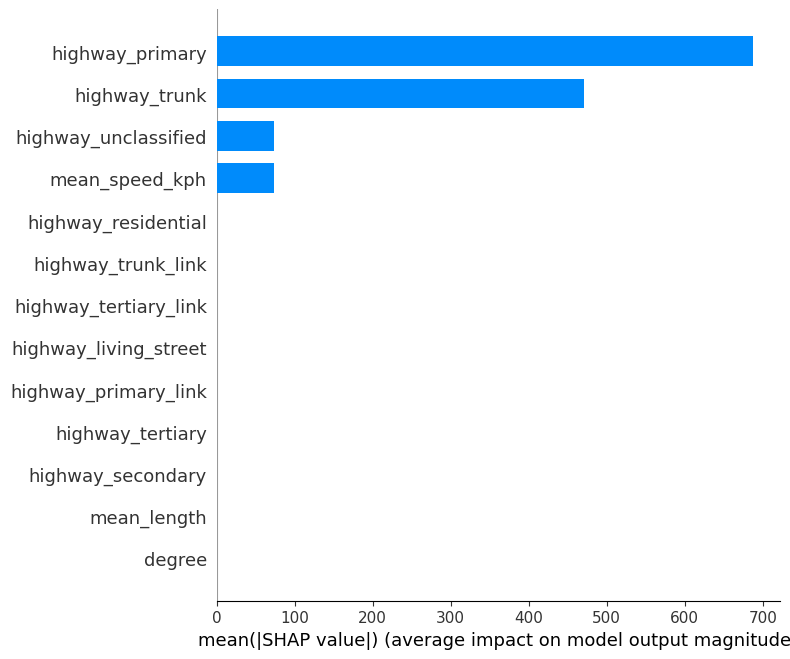

No 'borough' column on nodes. If you have borough polygons, create it via spatial join.
Example:
  borough_gdf = gpd.read_file('london_boroughs.shp').to_crs(nodes.crs)
  nodes['borough'] = gpd.sjoin(nodes, borough_gdf, how='left').borough_name


In [ ]:

import shap

X = data.x.cpu().numpy()
y_occ = data.y.cpu().numpy()

train_idx = np.where(data.train_mask_occ.cpu().numpy())[0]
test_idx  = np.where(data.test_mask_occ.cpu().numpy())[0]

explainer = shap.TreeExplainer(xgb_occ)
shap_vals = explainer.shap_values(X[test_idx])

# Global importance
print("Global SHAP importance:")
shap.summary_plot(shap_vals, X[test_idx], feature_names=feat_cols, plot_type="bar")

# Borough drift (needs borough per node)
if "borough" in nodes.columns:
    boroughs = nodes["borough"].values[test_idx]
    drift = []
    for b in np.unique(boroughs):
        m = boroughs == b
        if m.sum() < 50:
            continue
        mean_abs = np.abs(shap_vals[m]).mean(axis=0)
        drift.append(pd.Series(mean_abs, index=feat_cols, name=b))
    drift_df = pd.DataFrame(drift)
    display(drift_df.sort_index())

    # optional heatmap
    drift_df.T.plot(kind="bar", figsize=(12,4), title="Mean |SHAP| by Borough")
else:
    print(
        "No 'borough' column on nodes. If you have borough polygons, create it via spatial join.\n"
        "Example:\n"
        "  borough_gdf = gpd.read_file('london_boroughs.shp').to_crs(nodes.crs)\n"
        "  nodes['borough'] = gpd.sjoin(nodes, borough_gdf, how='left').borough_name"
    )


CELL 23 — extract attention weights from TransformerConv

In [ ]:

def get_attention_weights(model, edge_attr):
    model.eval()
    with torch.no_grad():
        # ask conv1 for attention
        h1, (ei1, alpha1) = model.conv1(
            data.x, data.edge_index, edge_attr,
            return_attention_weights=True
        )
        # alpha1 shape: [num_edges, heads]
        attn = alpha1.mean(dim=1).cpu().numpy()
        ei = ei1.cpu().numpy()
    return ei, attn

ei, attn = get_attention_weights(model_occ_full, data.edge_attr_full)

attn_df = pd.DataFrame({
    "u": ei[0],
    "v": ei[1],
    "attn": attn
}).sort_values("attn", ascending=False)

print(attn_df.head(10))

# If edges GeoDataFrame exists, attach attention for mapping
try:
    edges_attn = edges.copy()
    edges_attn["u_idx"] = edges_attn.index.get_level_values(0).map(node_id_to_idx)
    edges_attn["v_idx"] = edges_attn.index.get_level_values(1).map(node_id_to_idx)
    key = pd.MultiIndex.from_arrays([attn_df.u, attn_df.v])
    attn_map = pd.Series(attn_df.attn.values, index=key)
    edges_attn["attn"] = [
        attn_map.get((u,v), np.nan) for u,v in zip(edges_attn.u_idx, edges_attn.v_idx)
    ]
    print("Edges with attention:", edges_attn["attn"].notna().mean())
except Exception as e:
    print("Couldn't attach attention to edges GeoDF:", e)


             u       v  attn
32          11   41867   1.0
303766  130516   78476   1.0
303769  130517  130519   1.0
303768  130517  130518   1.0
127068   48713   79731   1.0
127057   48709   48708   1.0
127058   48709   48710   1.0
127163   48751   48752   1.0
127154   48748   48749   1.0
127071   48714  125547   1.0


/tmp/ipython-input-583190297.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  attn_map.get((u,v), np.nan) for u,v in zip(edges_attn.u_idx, edges_attn.v_idx)


Edges with attention: 1.0


CELL 24 — optional count regression baselines

In [ ]:

!pip install -q statsmodels

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Build a modeling DF at node level
node_df = nodes.copy()
node_df["acc_count"] = cnt_labels
for c in feat_cols:
    node_df[c] = node_df[c].astype(float)

# Poisson
formula = "acc_count ~ " + " + ".join(feat_cols)
pois = smf.glm(formula=formula, data=node_df, family=sm.families.Poisson()).fit()
print(pois.summary().tables[1])

# NegBin (overdispersion)
nb = smf.glm(formula=formula, data=node_df,
             family=sm.families.NegativeBinomial(alpha=1.0)).fit()
print(nb.summary().tables[1])

# Zero-Inflated NB (if available)
try:
    from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
    endog = node_df["acc_count"].values
    exog  = sm.add_constant(node_df[feat_cols].values)
    zinb = ZeroInflatedNegativeBinomialP(endog, exog, exog_infl=exog, inflation="logit").fit(disp=0)
    print(zinb.summary())
except Exception as e:
    print("ZINB not fitted (ok):", e)


                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.4831      0.035    -71.957      0.000      -2.551      -2.415
degree                    0.2845      0.008     37.475      0.000       0.270       0.299
mean_length               0.0016   2.89e-05     56.288      0.000       0.002       0.002
mean_speed_kph           -0.0159      0.001    -24.460      0.000      -0.017      -0.015
highway_residential       0.1543      0.015     10.478      0.000       0.125       0.183
highway_primary           1.6347      0.013    129.699      0.000       1.610       1.659
highway_tertiary          0.8163      0.014     59.398      0.000       0.789       0.843
highway_unclassified      0.4354      0.017     25.312      0.000       0.402       0.469
highway_secondary         1.0288      0.017     60.600      0.000       0.996       1.062
highway_tr

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:4329: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:3936: RuntimeWarning: invalid value encountered in subtract
  llf = (gammaln(y + a1) - gammaln(y + 1) - gammaln(a1)

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:               130536
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                   130522
Method:                                      MLE   Df Model:                           13
Date:                           Fri, 21 Nov 2025   Pseudo R-squ.:                     nan
Time:                                   09:27:38   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -92389.
Covariance Type:                       nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -5.3872        nan        nan        nan         nan         nan
inflate_x1      -16.6068        na

 CELL 25— publication-quality risk map

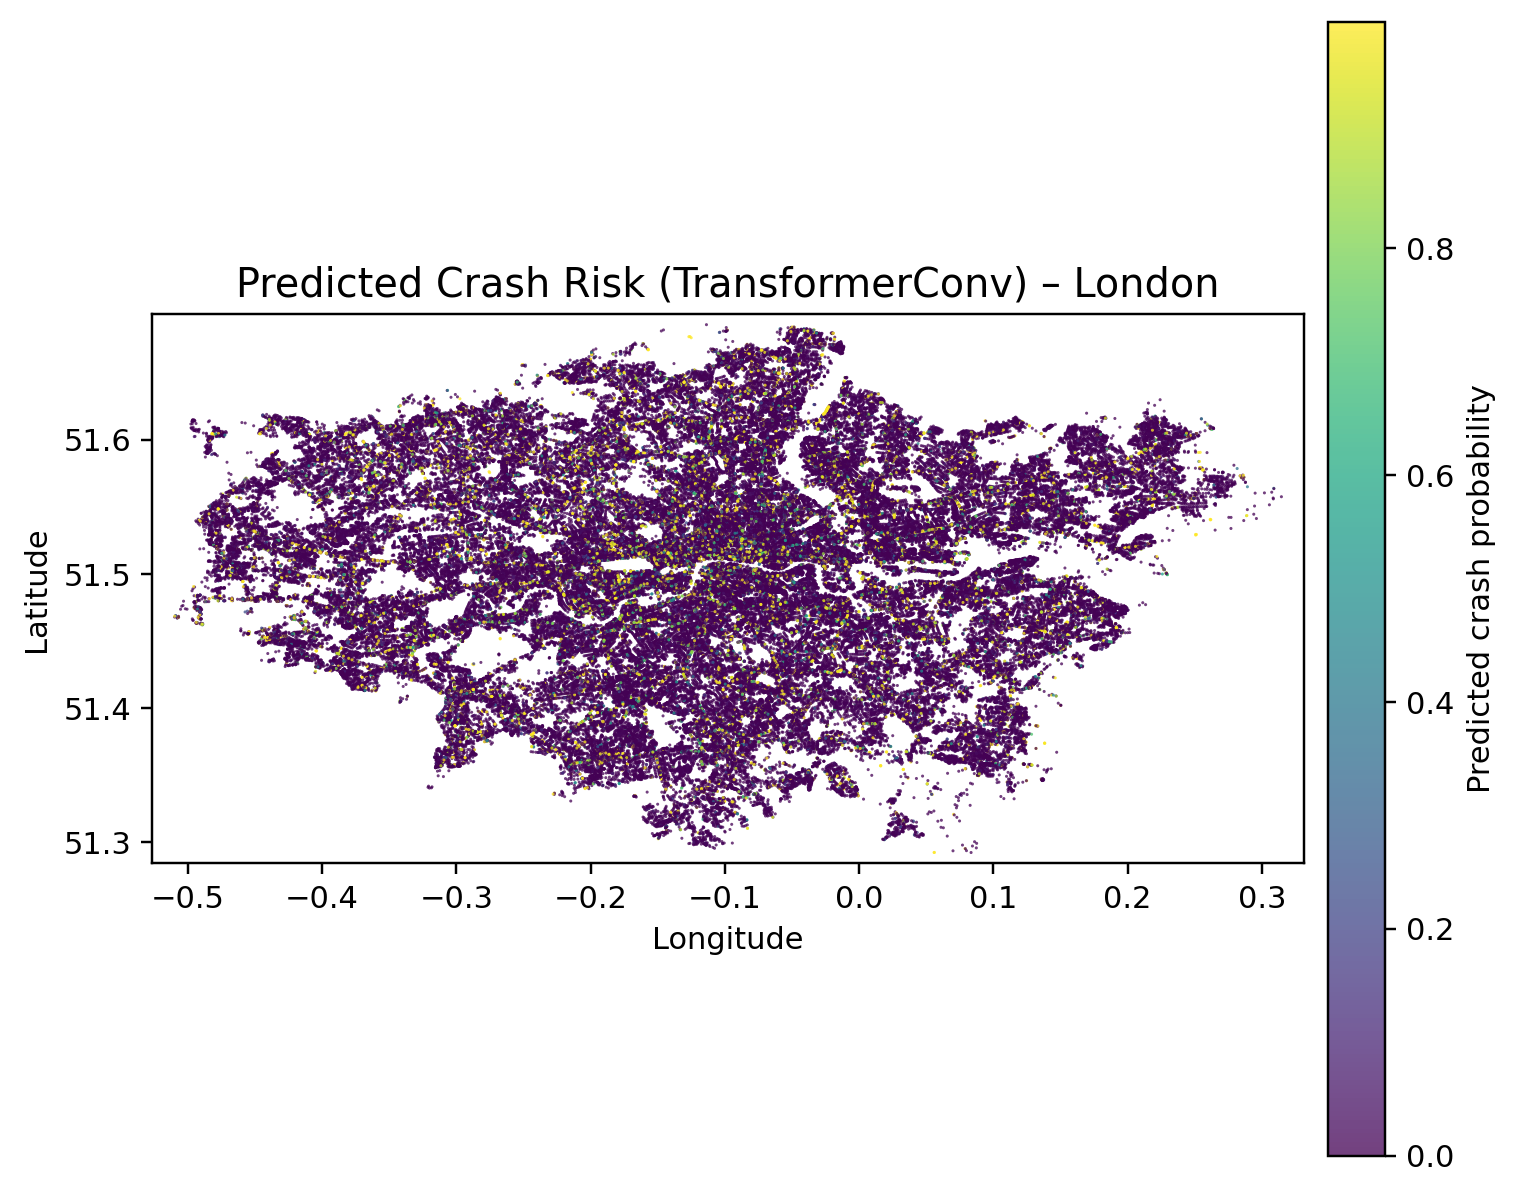

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

# --- get lon/lat/probs from risk_df if it exists, else from coords+probs ---
if "risk_df" in globals():
    lon = risk_df["lon"].values
    lat = risk_df["lat"].values
    p   = risk_df["p_crash"].values
else:
    # expects coords = (lat, lon) and probs already computed
    lon = coords[:, 1]
    lat = coords[:, 0]
    p   = probs

# --- contrast stretch for nicer colors (robust to outliers) ---
vmin = np.quantile(p, 0.02)
vmax = np.quantile(p, 0.98)

plt.figure(figsize=(7, 7), dpi=220)

sc = plt.scatter(
    lon, lat,
    s=1.0,                 # tiny points like screenshot
    c=p,
    cmap="viridis",
    vmin=vmin, vmax=vmax,
    alpha=0.75,
    linewidths=0,
    rasterized=True        # keeps PDF size small if you export
)

plt.title("Predicted Crash Risk (TransformerConv) – London", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# equal aspect so London doesn't look squashed
plt.gca().set_aspect("equal", adjustable="box")

# set clean bounds (little padding)
pad_x = (lon.max() - lon.min()) * 0.02
pad_y = (lat.max() - lat.min()) * 0.02
plt.xlim(lon.min() - pad_x, lon.max() + pad_x)
plt.ylim(lat.min() - pad_y, lat.max() + pad_y)

# light, clean spines
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.8)

cbar = plt.colorbar(sc, fraction=0.046, pad=0.02)
cbar.set_label("Predicted crash probability", rotation=90)

plt.tight_layout()
plt.show()


CONFUSION MATRIX: OCCURRENCE

<Figure size 640x640 with 0 Axes>

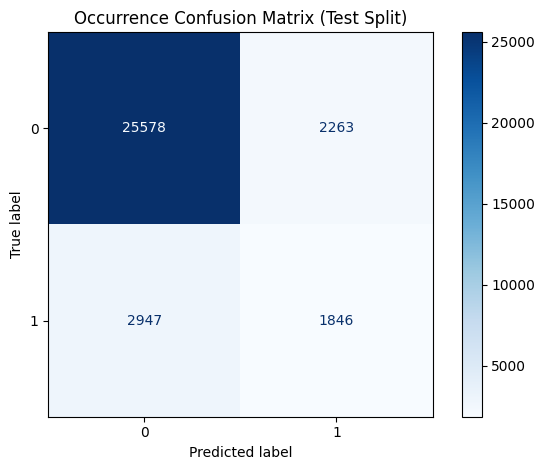

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_idx = np.where(data.test_mask_occ.cpu().numpy())[0]
y_test = data.y.cpu().numpy()[test_idx]

# choose predictions to plot:
# preds_to_plot = pred_occ_full.cpu().numpy()[test_idx]      # Transformer full
# preds_to_plot = pred_occ_mt.cpu().numpy()[test_idx]        # MultiTask
preds_to_plot = pred_occ_xgb                               # XGB baseline (already test-only)

cm = confusion_matrix(y_test, preds_to_plot, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

plt.figure(figsize=(4,4), dpi=160)
disp.plot(values_format="d", cmap="Blues")
plt.title("Occurrence Confusion Matrix (Test Split)")
plt.tight_layout()
plt.show()


CONFUSION MATRIX: SEVERITY

<Figure size 1020x1020 with 0 Axes>

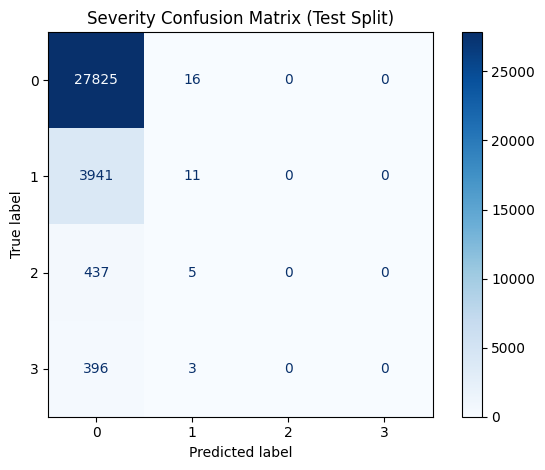

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

test_idx = np.where(data.test_mask_sev.cpu().numpy())[0]
y_test = data.severity_labels.cpu().numpy()[test_idx]

# choose predictions to plot:
preds_to_plot = pred_sev_full.cpu().numpy()[test_idx]   # Transformer full
# preds_to_plot = pred_sev_mt.cpu().numpy()[test_idx]   # MultiTask
# preds_to_plot = pred_sev_xgb                          # XGB (already test-only)

labels = np.arange(int(data.severity_labels.max().item() + 1))

cm = confusion_matrix(y_test, preds_to_plot, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6,6), dpi=170)
disp.plot(values_format="d", cmap="Blues")
plt.title("Severity Confusion Matrix (Test Split)")
plt.tight_layout()
plt.show()


install optuna (run once)

In [ ]:

!pip install -q optuna
import optuna


Optuna hyperparameter search for TransformerConv (occurrence + severity)

In [ ]:


from sklearn.metrics import f1_score
import numpy as np
import torch

def tune_transformer(task="occurrence", n_trials=30, epochs=40, edge_kind="full"):
    """
    task: 'occurrence' or 'severity'
    edge_kind: 'full' or 'basic'
    returns: best_params dict
    """

    if edge_kind == "full":
        edge_attr = data.edge_attr_full
    else:
        edge_attr = data.edge_attr_basic

    if task == "occurrence":
        y  = data.y
        tr = data.train_mask_occ
        va = data.val_mask_occ
        num_classes = int(y.max().item() + 1)

        def loss_fn(out, lab):
            return focal_occ(out, lab)   # uses your focal loss
    else:
        y  = data.severity_labels
        tr = data.train_mask_sev
        va = data.val_mask_sev
        num_classes = int(y.max().item() + 1)

        def loss_fn(out, lab):
            return F.cross_entropy(out, lab)

    in_dim  = data.x.size(1)
    edge_dim = edge_attr.size(1)

    def objective(trial):
        hidden  = trial.suggest_categorical("hidden", [32, 64, 128, 256])
        heads   = trial.suggest_categorical("heads", [2, 4, 8])
        dropout = trial.suggest_float("dropout", 0.2, 0.7)
        lr      = trial.suggest_float("lr", 5e-4, 5e-3, log=True)
        wd      = trial.suggest_float("weight_decay", 1e-6, 5e-4, log=True)

        model = TransformerNet(
            in_dim=in_dim,
            hidden_dim=hidden,
            out_dim=num_classes,
            edge_dim=edge_dim,
            heads=heads,
            dropout=dropout
        ).to(device)

        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        # short training per trial
        for _ in range(epochs):
            model.train()
            opt.zero_grad()
            out = model(data.x, data.edge_index, edge_attr)
            loss = loss_fn(out[tr], y[tr])
            loss.backward()
            opt.step()

        # validation macro-F1
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index, edge_attr)
            pred = out.argmax(dim=1)
            val_f1 = f1_score(
                y[va].cpu().numpy(),
                pred[va].cpu().numpy(),
                average="macro"
            )
        return val_f1

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nBest params for {task} ({edge_kind} edges):")
    print(study.best_params)
    print("Best val macro-F1:", round(study.best_value, 4))

    return study.best_params


tune occurrence

In [ ]:

import optuna
import torch
import torch.nn.functional as F

# Define the missing focal loss function (needed by tune_transformer)
def focal_occ(inputs, targets, alpha=0.25, gamma=2.0):
    ce_loss = F.cross_entropy(inputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    return loss.mean()

best_occ_params = tune_transformer(
    task="occurrence",
    n_trials=35,     # bump to 50 if you have time
    epochs=40,
    edge_kind="full"
)
best_occ_params

[I 2025-11-21 09:52:38,688] A new study created in memory with name: no-name-1e32516c-d041-46da-9bc1-06b6791ad905


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-11-21 09:52:43,590] Trial 0 finished with value: 0.6220882863181113 and parameters: {'hidden': 256, 'heads': 8, 'dropout': 0.36465513399909466, 'lr': 0.002182433237978231, 'weight_decay': 6.589682966932062e-06}. Best is trial 0 with value: 0.6220882863181113.
[I 2025-11-21 09:52:46,211] Trial 1 finished with value: 0.5667826891078982 and parameters: {'hidden': 128, 'heads': 8, 'dropout': 0.4312813211495906, 'lr': 0.0016260533199760772, 'weight_decay': 7.866840601510283e-05}. Best is trial 0 with value: 0.6220882863181113.
[I 2025-11-21 09:52:48,837] Trial 2 finished with value: 0.4729184046788538 and parameters: {'hidden': 128, 'heads': 8, 'dropout': 0.5353455533324728, 'lr': 0.0009207082616266711, 'weight_decay': 1.2026645754721345e-06}. Best is trial 0 with value: 0.6220882863181113.
[I 2025-11-21 09:52:53,719] Trial 3 finished with value: 0.48012149475308213 and parameters: {'hidden': 256, 'heads': 8, 'dropout': 0.6938528281898066, 'lr': 0.003747553458603867, 'weight_decay':

{'hidden': 256,
 'heads': 4,
 'dropout': 0.39757574004112173,
 'lr': 0.00415959044653718,
 'weight_decay': 1.6652063075959714e-05}

tune severity

In [ ]:

best_sev_params = tune_transformer(
    task="severity",
    n_trials=35,
    epochs=40,
    edge_kind="full"
)
best_sev_params

[I 2025-11-21 09:53:51,267] A new study created in memory with name: no-name-9b1fc8de-6068-4f50-8669-a9b0e5a9dc1d


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-11-21 09:53:52,112] Trial 0 finished with value: 0.015843621399176954 and parameters: {'hidden': 128, 'heads': 2, 'dropout': 0.20792519673568027, 'lr': 0.0016366165034290357, 'weight_decay': 6.424455454629188e-05}. Best is trial 0 with value: 0.015843621399176954.
[I 2025-11-21 09:53:52,525] Trial 1 finished with value: 0.050129485756566776 and parameters: {'hidden': 32, 'heads': 2, 'dropout': 0.22360874330398828, 'lr': 0.003429642442356523, 'weight_decay': 0.00022402363050885973}. Best is trial 1 with value: 0.050129485756566776.
[I 2025-11-21 09:53:53,405] Trial 2 finished with value: 0.027156549520766772 and parameters: {'hidden': 64, 'heads': 4, 'dropout': 0.2417554072416161, 'lr': 0.0021922793845656485, 'weight_decay': 8.257523738249814e-05}. Best is trial 1 with value: 0.050129485756566776.
[I 2025-11-21 09:53:53,990] Trial 3 finished with value: 0.0006476683937823834 and parameters: {'hidden': 32, 'heads': 4, 'dropout': 0.31384101705805023, 'lr': 0.0006026010350757171, '

{'hidden': 256,
 'heads': 8,
 'dropout': 0.28863414941520876,
 'lr': 0.0026069026628251094,
 'weight_decay': 7.901675763691618e-06}

final training with best hyperparams

In [ ]:


from sklearn.metrics import f1_score, classification_report
import torch.nn.functional as F
import torch
import numpy as np

def train_final(task, best_params, epochs=120, edge_kind="full"):
    # 1. Setup Data Variables based on Task
    if task == "occurrence":
        y = data.y
        train_mask = data.train_mask_occ
        val_mask   = data.val_mask_occ
        test_mask  = data.test_mask_occ
        num_classes = int(y.max().item() + 1)
        # Loss function: prefer focal_occ if available, else CrossEntropy
        if "focal_occ" in globals():
            loss_fn = lambda o, t: focal_occ(o, t)
        else:
            loss_fn = F.cross_entropy
    else:
        # severity
        y = data.severity_labels
        train_mask = data.train_mask_sev
        val_mask   = data.val_mask_sev
        test_mask  = data.test_mask_sev
        num_classes = int(y.max().item() + 1)
        loss_fn = F.cross_entropy

    # 2. Setup Edge Attributes
    if edge_kind == "full":
        edge_attr = data.edge_attr_full
    else:
        edge_attr = data.edge_attr_basic

    edge_dim = edge_attr.size(1)
    in_dim = data.x.size(1)

    # 3. Initialize Model with Best Params
    model = TransformerNet(
        in_dim=in_dim,
        hidden_dim=best_params["hidden"],
        out_dim=num_classes,
        edge_dim=edge_dim,
        heads=best_params["heads"],
        dropout=best_params["dropout"]
    ).to(device)

    # 4. Optimizer
    opt = torch.optim.Adam(
        model.parameters(),
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"]
    )

    # 5. Training Loop
    print(f"Starting training for {task} ({edge_kind}) with params: {best_params}")

    for epoch in range(1, epochs + 1):
        model.train()
        opt.zero_grad()
        out = model(data.x, data.edge_index, edge_attr)
        loss = loss_fn(out[train_mask], y[train_mask])
        loss.backward()
        opt.step()

        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                logits_val = model(data.x, data.edge_index, edge_attr)
                preds_val = logits_val.argmax(dim=1)
                val_f1 = f1_score(
                    y[val_mask].cpu().numpy(),
                    preds_val[val_mask].cpu().numpy(),
                    average="macro"
                )
            print(f"Epoch {epoch:03d} | Loss {loss.item():.4f} | Val macro-F1 {val_f1:.3f}")

    # 6. Final Evaluation on Test
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index, edge_attr)
        preds = logits.argmax(dim=1)

    print(f"\n[{task.upper()}] Final Test Report:")
    print(classification_report(
        y[test_mask].cpu().numpy(),
        preds[test_mask].cpu().numpy(),
        digits=3
    ))

    return model, preds, logits

print("=== FINAL OCCURRENCE MODEL ===")
final_occ_model, final_pred_occ, final_logits_occ = train_final(
    "occurrence", best_occ_params, epochs=120, edge_kind="full"
)

print("\n=== FINAL SEVERITY MODEL ===")
final_sev_model, final_pred_sev, final_logits_sev = train_final(
    "severity", best_sev_params, epochs=120, edge_kind="full"
)

=== FINAL OCCURRENCE MODEL ===
Starting training for occurrence (full) with params: {'hidden': 256, 'heads': 4, 'dropout': 0.39757574004112173, 'lr': 0.00415959044653718, 'weight_decay': 1.6652063075959714e-05}
Epoch 020 | Loss 1.1258 | Val macro-F1 0.505
Epoch 040 | Loss 0.4352 | Val macro-F1 0.448
Epoch 060 | Loss 1.0860 | Val macro-F1 0.467
Epoch 080 | Loss 0.2535 | Val macro-F1 0.448
Epoch 100 | Loss 0.2681 | Val macro-F1 0.443
Epoch 120 | Loss 0.1490 | Val macro-F1 0.445

[OCCURRENCE] Final Test Report:
              precision    recall  f1-score   support

           0      0.854     0.999     0.921     27841
           1      0.611     0.009     0.018      4793

    accuracy                          0.854     32634
   macro avg      0.733     0.504     0.470     32634
weighted avg      0.818     0.854     0.788     32634


=== FINAL SEVERITY MODEL ===
Starting training for severity (full) with params: {'hidden': 256, 'heads': 8, 'dropout': 0.28863414941520876, 'lr': 0.0026069026

Borough accident risk ranking plot (Matplotlib)

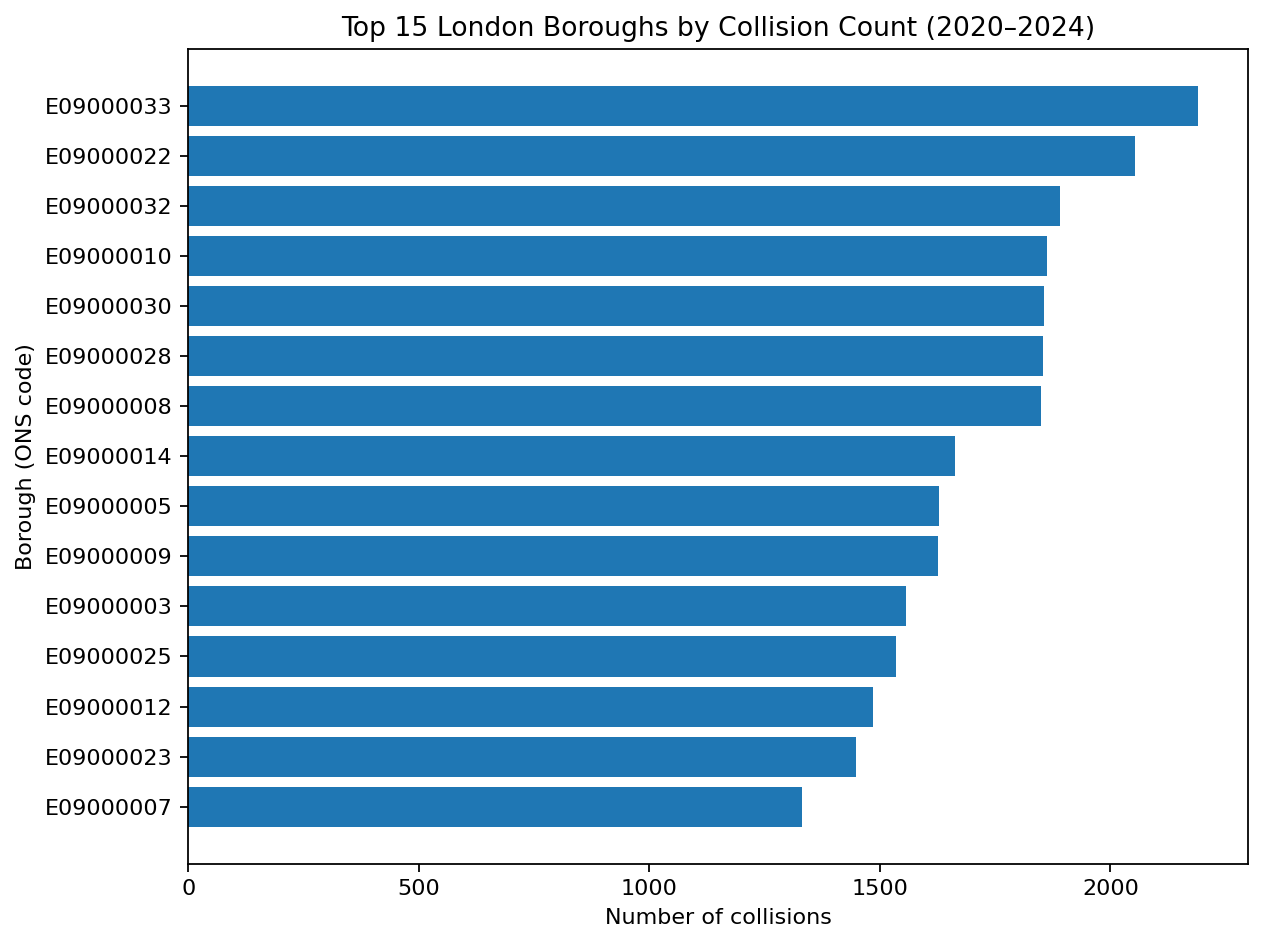

,local_authority_ons_district,collisions
0,E09000033,2189
1,E09000022,2053
2,E09000032,1890
3,E09000010,1863
4,E09000030,1857
5,E09000028,1853
6,E09000008,1850
7,E09000014,1662
8,E09000005,1629
9,E09000009,1627


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- use existing df_london if available, else rebuild safely ---
if "df_london" in globals():
    df_use = df_london.copy()
else:
    DATA_PATH = "collisions_with_datetime.csv"  # adjust if needed
    df_use = pd.read_csv(DATA_PATH)

    # ensure datetime
    if "datetime" in df_use.columns:
        df_use["datetime"] = pd.to_datetime(df_use["datetime"])
    elif {"date","time"}.issubset(df_use.columns):
        df_use["datetime"] = pd.to_datetime(df_use["date"].astype(str) + " " + df_use["time"].astype(str))

    # filter years
    if "collision_year" in df_use.columns:
        df_use = df_use[(df_use["collision_year"]>=2020) & (df_use["collision_year"]<=2024)]
    else:
        df_use = df_use[(df_use["datetime"].dt.year>=2020) & (df_use["datetime"].dt.year<=2024)]

    df_use = df_use.dropna(subset=["longitude","latitude"])

    # london filter
    if "local_authority_ons_district" in df_use.columns:
        df_use = df_use[df_use["local_authority_ons_district"].astype(str).str.startswith("E09")]

# borough column (ONS codes are best)
BOROUGH_COL = "local_authority_ons_district" if "local_authority_ons_district" in df_use.columns else "local_authority_district"

# collisions per borough
borough_counts = (
    df_use.groupby(BOROUGH_COL)
          .size()
          .sort_values(ascending=False)
          .rename("collisions")
          .reset_index()
)

# --- plot top N for readability ---
top_n = 15
top = borough_counts.head(top_n).iloc[::-1]  # reverse for horizontal bars

plt.figure(figsize=(8,6), dpi=160)
plt.barh(top[BOROUGH_COL].astype(str), top["collisions"])
plt.title(f"Top {top_n} London Boroughs by Collision Count (2020–2024)")
plt.xlabel("Number of collisions")
plt.ylabel("Borough (ONS code)")
plt.tight_layout()
plt.show()

# show full ranking table too
borough_counts

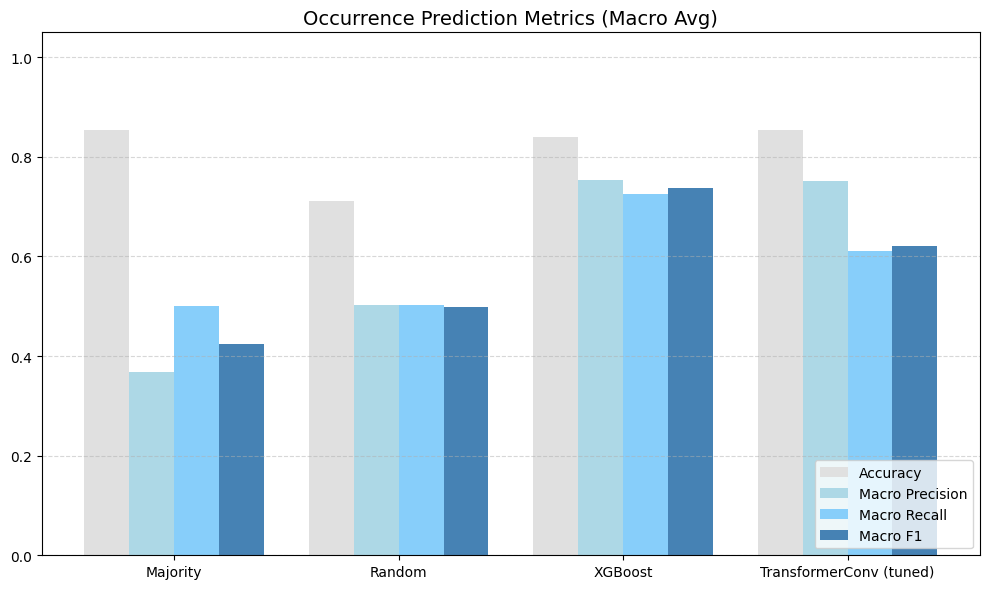

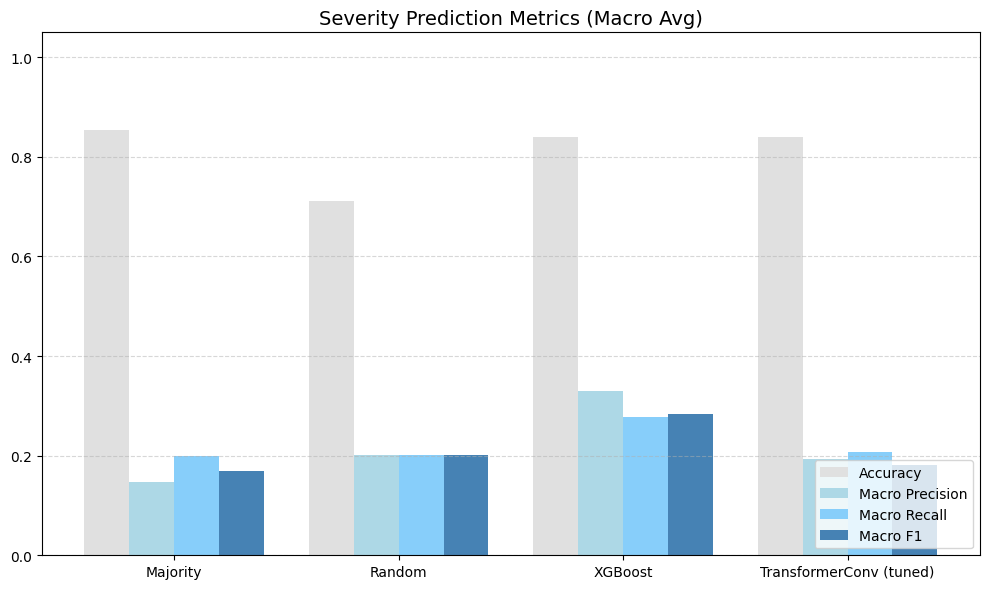

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

models = ["Majority", "Random", "XGBoost", "TransformerConv (tuned)"]

# Occurrence metrics (macro) from your reports
occ = pd.DataFrame({
    "Model": models,
    "Accuracy":        [0.853, 0.711, 0.840, 0.854],
    "Macro Precision": [0.368, 0.502, 0.754, 0.752],
    "Macro Recall":    [0.500, 0.502, 0.726, 0.610],
    "Macro F1":        [0.424, 0.498, 0.737, 0.621],
})

# Severity metrics (macro) from your reports
sev = pd.DataFrame({
    "Model": models,
    "Accuracy":        [0.853, 0.711, 0.840, 0.840],
    "Macro Precision": [0.147, 0.201, 0.330, 0.193],
    "Macro Recall":    [0.200, 0.202, 0.277, 0.207],
    "Macro F1":        [0.170, 0.201, 0.283, 0.182],
})

def plot_metrics(df, title):
    plt.figure(figsize=(10, 6), dpi=100)
    x = list(range(len(df)))
    w = 0.2

    plt.bar([i - 1.5*w for i in x], df["Accuracy"],        width=w, label="Accuracy", color="#e0e0e0")
    plt.bar([i - 0.5*w for i in x], df["Macro Precision"], width=w, label="Macro Precision", color="#add8e6")
    plt.bar([i + 0.5*w for i in x], df["Macro Recall"],    width=w, label="Macro Recall", color="#87cefa")
    plt.bar([i + 1.5*w for i in x], df["Macro F1"],        width=w, label="Macro F1", color="#4682b4")

    plt.xticks(x, df["Model"])
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

plot_metrics(occ, "Occurrence Prediction Metrics (Macro Avg)")
plot_metrics(sev, "Severity Prediction Metrics (Macro Avg)")